In [147]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Build Data Structures

In [217]:
import nn_visualize as V

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


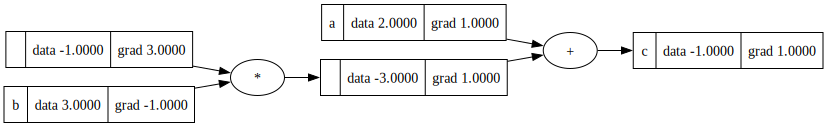

In [174]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a - b; c.label = 'c'
c.backward()
V.draw_dot(c)

In [175]:
print(c)

Value(data=-1.0)


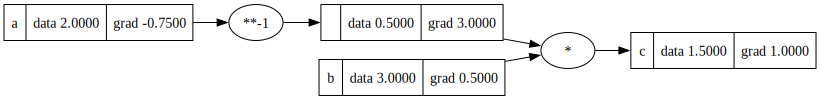

In [172]:
# division

a = Value(2.0, label='a')
b = Value(3.0, label='b')

# a / b = a * (b)^-1
# so we need to implement x^k in value class where k is a scaler int or float value
c = b/a; c.label = 'c'
c.backward()
V.draw_dot(c)

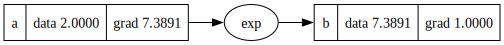

In [166]:
a = Value(2.0, label='a')
b = a.exp(); b.label = 'b'
b.backward()
V.draw_dot(b)

In [167]:
math.exp(2.0)

7.38905609893065

In [176]:

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870, label='b')

x1w1 = x1 * w1 ; x1w1.label='x1*w1'
x2w2 = x2 * w2 ; x2w2.label='x2*w2'

x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_plus_x2w2 + b; n.label = 'n' # output of neuron before activation

o = n.tanh(); o.label = 'o'

o.backward()

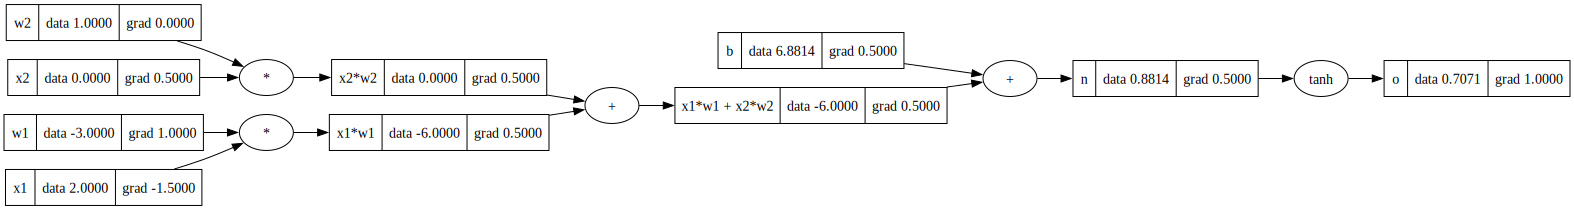

In [178]:
V.draw_dot(o)

# tanh using exponent

![title](../../images/tanh_func_1.png)

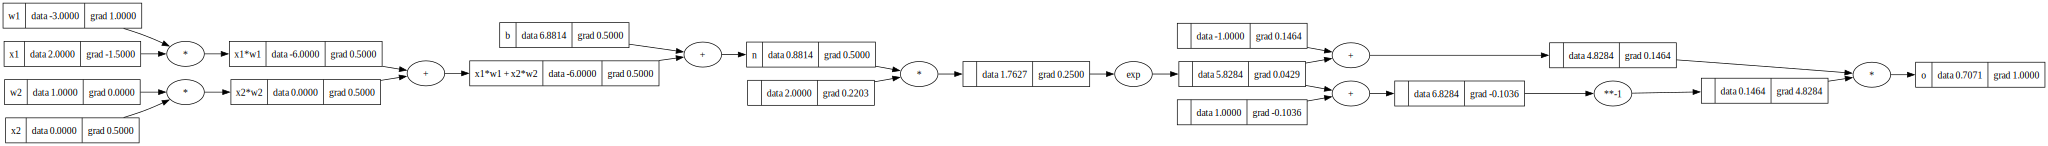

In [179]:

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870, label='b')

x1w1 = x1 * w1 ; x1w1.label='x1*w1'
x2w2 = x2 * w2 ; x2w2.label='x2*w2'

x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_plus_x2w2 + b; n.label = 'n' # output of neuron before activation

# find o  = tanh(n)
e = (2 * n ).exp()
o = (e - 1)/(e + 1); o.label='o'

o.backward()
V.draw_dot(o)

# Lets create NN

In [224]:
import random


class Neuron:

    def __init__(self, nin):
        """
        Takes number of input neurons as nin
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
        self.b = Value(random.uniform(-1,1)) # bias

    
    def __call__(self, x): # same like apply in scala
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # pre activation
        out = act.tanh() # post activation
        return out
    
    def parameters(self):
        return self.w + [self.b]


In [225]:
from typing import Any


class Layer:

    def __init__(self, nin, nout):
        """
        nin : number of inputs
        nout: number of outputs
        """
        self.neurons = [Neuron(nin) for _ in range(nout)] # number of outputs = number of neurons in layer
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [226]:
from typing import Any


class MLP:

    def __init__(self, nin, nouts):
        """
        nin: number of inputs
        nouts: list of number of neurons in each layer

        so MLP(2,[3,3,1]) is asking for a MLP with 2 inputs and 3 layers with 3,3,1 neurons in each layer
        """

        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [334]:
mlp = MLP(3,[4,4,1])
x = [2.0,3.0,4.0]
mlp(x)

Value(data=-0.6880825793039429)

In [335]:
mlp.parameters()

[Value(data=-0.7961970147245439),
 Value(data=-0.4107011097282236),
 Value(data=-0.7838282799253191),
 Value(data=0.9781001541864018),
 Value(data=-0.8829614727117951),
 Value(data=-0.19733916669876805),
 Value(data=0.489872810287588),
 Value(data=-0.9134008017003163),
 Value(data=0.2949814919330731),
 Value(data=-0.6257937356284364),
 Value(data=0.3577415973936249),
 Value(data=-0.503142647979459),
 Value(data=0.511512003753055),
 Value(data=0.11954973316478212),
 Value(data=0.9752058389388745),
 Value(data=0.023054241165219258),
 Value(data=0.5720547960109308),
 Value(data=0.7133564226170293),
 Value(data=0.9095885312227046),
 Value(data=-0.6116385008645802),
 Value(data=-0.7079174137760926),
 Value(data=0.04393394211984902),
 Value(data=0.4774387121371837),
 Value(data=0.1209006543186173),
 Value(data=0.737402881725671),
 Value(data=-0.7002648121070107),
 Value(data=0.6955763479010171),
 Value(data=0.16431091766671035),
 Value(data=0.15376477161252167),
 Value(data=0.903733397515377

In [333]:
import nn_visualize as V

#V.draw_dot(mlp(x)) # this is too large

Lets train a binary classifier

In [336]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [373]:
mlp = MLP(3,[4,4,1])

for k in range(100):

    # forward pass
    ypred = [mlp(x) for x in xs] 
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in mlp.parameters():
        # this is called 0 grading. Need to set the old gradiesnt 0 before I calculate new gradients
        # If this is not done, gradients will keep adding
        p.grad = 0.0 
    loss.backward()

    # update weights
    for p in mlp.parameters():
        p.data +=  - (0.05 * p.grad) # - because we want to reduce the loss


    print(k, loss) 
    

0 Value(data=5.062001516849143)
1 Value(data=3.7073184997254556)
2 Value(data=2.6871074214378257)
3 Value(data=1.5653313746657274)
4 Value(data=0.8471211160364542)
5 Value(data=0.5314676828521393)
6 Value(data=0.37499811167475683)
7 Value(data=0.28465681096498247)
8 Value(data=0.22676621805265473)
9 Value(data=0.18693438970905607)
10 Value(data=0.15808352766299955)
11 Value(data=0.13635971680976894)
12 Value(data=0.11949714512424613)
13 Value(data=0.1060824296698683)
14 Value(data=0.09519162769926778)
15 Value(data=0.08619737490990159)
16 Value(data=0.0786600823588689)
17 Value(data=0.07226345536845069)
18 Value(data=0.06677467826961721)
19 Value(data=0.062018962125332436)
20 Value(data=0.05786278371494251)
21 Value(data=0.054202560003571404)
22 Value(data=0.05095682055131362)
23 Value(data=0.04806068811650541)
24 Value(data=0.04546191654500882)
25 Value(data=0.043118000349720687)
26 Value(data=0.040994035072090665)
27 Value(data=0.03906111217665057)
28 Value(data=0.03729510016095659)


In [375]:
print(ypred)

[Value(data=0.962967032702042), Value(data=-0.9482739961645927), Value(data=-0.9497378145807245), Value(data=0.9572273421182399)]


In [337]:
# outputs in first round with randomly initialized weights and biases
ypred = [mlp(x) for x in xs] 
ypred

[Value(data=-0.2615047944162681),
 Value(data=-0.7803865437084441),
 Value(data=-0.7674205081960007),
 Value(data=-0.540634516910365)]

In [338]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.067272351222995)

In [339]:
loss.backward()

In [340]:
mlp.layers[0].neurons[0].w[0].grad

2.303362663124253

In [223]:
# V.draw_dot(loss) # This is very large

In [365]:
for p in mlp.parameters():
    p.data +=  - (0.05 * p.grad) # - because we want to reduce the loss 

In [366]:
ypred = [mlp(x) for x in xs] 
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.18895299192603005)

In [367]:
loss.backward()

In [368]:
ypred

[Value(data=0.6711718953232136),
 Value(data=-0.9981643501310852),
 Value(data=-0.9969404946982836),
 Value(data=0.7157248879736919)]

In [369]:
mlp.parameters()

[Value(data=-1.1721116641088227),
 Value(data=-1.0223990720382101),
 Value(data=0.4635018142899441),
 Value(data=0.9453341889785684),
 Value(data=-0.6773361031804646),
 Value(data=0.19362193061823402),
 Value(data=0.905948778262194),
 Value(data=-0.5128071940078628),
 Value(data=0.756812627039866),
 Value(data=-0.2844334842793816),
 Value(data=1.0006262898212541),
 Value(data=0.0514693224296163),
 Value(data=-0.2753521025054356),
 Value(data=-1.5827879076603155),
 Value(data=3.204672428187642),
 Value(data=-0.0761756295833556),
 Value(data=0.5865193335758552),
 Value(data=0.6857262443062723),
 Value(data=0.87469170967113),
 Value(data=-0.6354203654813259),
 Value(data=-0.6805707511923866),
 Value(data=-0.5244770126646021),
 Value(data=-0.05770777918238776),
 Value(data=0.3075690898662563),
 Value(data=1.3773480254831445),
 Value(data=-0.0334796299722914),
 Value(data=-0.43399453121455106),
 Value(data=0.06064764790817544),
 Value(data=1.3128551148570433),
 Value(data=2.1867068089591912